# Generative Adversarial Network

## Pre-processing data

In [105]:
import tensorflow as tf
import numpy as np
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
tf.reset_default_graph()

In [106]:
    
## Here we will get the 100 000 first images and put them in a variable 178*218*3
data_size = 25001
def get_data(data_size=25001):
        dataset = []
        for x in range(1, data_size):
            imgname = "img_align_celeba/"
            for i in range(0, 6-len(str(x))):
                imgname += "0"
            imgname += str(x) + ".jpg"
            dataset.append(mpimg.imread(imgname))
        dataset =  np.array(dataset)
        print("Data loaded. Number of images: " + str(data_size))
        return dataset
    
def get_data_normalized(data_size=25001):
        dataset = []
        print("loading data...")
        for x in range(1, data_size):
            imgname = "img_align_celeba/"
            for i in range(0, 6-len(str(x))):
                imgname += "0"
            imgname += str(x) + ".jpg"
            dataset.append(mpimg.imread(imgname))
        dataset =  np.array(dataset)/256.0
        print("Data loaded. Number of images: " + str(data_size))
        return dataset
        
def get_batch(batch_size, dataset):
        indexes = np.random.randint(0, len(dataset), batch_size)
        data = dataset[indexes]
        return data

def sample_Z(batch_size=50, n=100):
        return np.random.uniform(-1., 1., size=[batch_size, n])

In [107]:
def generator_cnn(Z, fc_sizes=[110,200,300], output_dim=3, reuse=False, alpha=0.2, keep_prob=0.5,is_train=True):
    
    with tf.variable_scope("GAN/Generator",reuse=reuse):      
         # First fully connected layer, 4x4x1024
        fc = tf.layers.dense(Z, 25*20*1024, use_bias=False)
        fc = tf.reshape(fc, (-1, 25, 20, 1024))
        bn0 = tf.layers.batch_normalization(fc, training=is_train)
        lrelu0 = tf.maximum(alpha * bn0, bn0)
        drop0 = tf.layers.dropout(lrelu0, keep_prob, training=is_train)
        
        # Deconvolution, 7x7x512
        conv1 = tf.layers.conv2d_transpose(drop0, 512, 5, 2, 'valid', use_bias=False)
        bn1 = tf.layers.batch_normalization(conv1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        drop1 = tf.layers.dropout(lrelu1, keep_prob, training=is_train)
        
        # Deconvolution, 14x14x256
        conv2 = tf.layers.conv2d_transpose(drop1, 256, 5, 2, 'valid', use_bias=False)
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(lrelu2, keep_prob, training=is_train)
        
        # Output layer, 28x28xn
        logits = tf.layers.conv2d_transpose(drop2, output_dim, 5, 2, 'same')
        return logits


In [108]:
def discriminator_cnn(X, fc_sizes=[110,300,200], reuse=False, alpha=0.2, keep_prob=0.5):
    
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        # Input layer is 218x178x3
        # Convolutional layer, 109x89x64
        conv1 = tf.layers.conv2d(X, 64, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        drop1 = tf.layers.dropout(lrelu1, keep_prob)
        
        # Strided convolutional layer, 55x45x128
        conv2 = tf.layers.conv2d(drop1, 128, 5, 2, 'same', use_bias=False)
        bn2 = tf.layers.batch_normalization(conv2)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(lrelu2, keep_prob)
        
        # Strided convolutional layer, 28x23x256
        conv3 = tf.layers.conv2d(drop2, 256, 5, 2, 'same', use_bias=False)
        bn3 = tf.layers.batch_normalization(conv3)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.layers.dropout(lrelu3, keep_prob)
        
        # fully connected
        flat = tf.reshape(drop3, (-1, 28*23*256))
        out = tf.layers.dense(flat, 1)
        
        return out

In [109]:
X = tf.placeholder(tf.float32,[None,218,178,3])
XX = tf.reshape(X, shape=(tf.shape(X)[0], 218*178*3))
Z = tf.placeholder(tf.float32,[None,100])

In [110]:
G_sample = generator_cnn(Z)

In [111]:
r_logits = discriminator_cnn(X)
f_logits = discriminator_cnn(G_sample, reuse=True)

In [112]:
disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))


In [113]:
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step


loading data...
Data loaded. Number of images: 500
Iterations: 0	 Discriminator loss: 1.3770	 Generator loss: 0.7322
Iterations: 1	 Discriminator loss: 1.3470	 Generator loss: 0.7789
Iterations: 2	 Discriminator loss: 1.3020	 Generator loss: 0.8277
Iterations: 3	 Discriminator loss: 1.2498	 Generator loss: 0.8265
Iterations: 4	 Discriminator loss: 1.2420	 Generator loss: 0.8790
Iterations: 5	 Discriminator loss: 1.1929	 Generator loss: 0.9407
Iterations: 6	 Discriminator loss: 1.1220	 Generator loss: 0.9545
Iterations: 7	 Discriminator loss: 1.1390	 Generator loss: 0.9603
Iterations: 8	 Discriminator loss: 1.0881	 Generator loss: 0.9827
Iterations: 9	 Discriminator loss: 1.0475	 Generator loss: 0.9956
Iterations: 10	 Discriminator loss: 1.0527	 Generator loss: 1.0104
Iterations: 11	 Discriminator loss: 1.0122	 Generator loss: 1.0664
Iterations: 12	 Discriminator loss: 0.9777	 Generator loss: 1.0178
Iterations: 13	 Discriminator loss: 1.0008	 Generator loss: 1.0435
Iterations: 14	 Discr

Iterations: 121	 Discriminator loss: 0.1262	 Generator loss: 4.9370
Iterations: 122	 Discriminator loss: 0.0540	 Generator loss: 6.3429
Iterations: 123	 Discriminator loss: 0.1914	 Generator loss: 17.5993
Iterations: 124	 Discriminator loss: 0.9485	 Generator loss: 3.0514
Iterations: 125	 Discriminator loss: 5.8650	 Generator loss: 2.5594
Iterations: 126	 Discriminator loss: 1.2539	 Generator loss: 23.6274
Iterations: 127	 Discriminator loss: 3.9833	 Generator loss: 21.4092
Iterations: 128	 Discriminator loss: 8.4061	 Generator loss: 34.8678
Iterations: 129	 Discriminator loss: 4.7612	 Generator loss: 0.8853
Iterations: 130	 Discriminator loss: 3.4204	 Generator loss: 10.9879
Iterations: 131	 Discriminator loss: 1.3038	 Generator loss: 1.5674
Iterations: 132	 Discriminator loss: 1.1032	 Generator loss: 1.8375
Iterations: 133	 Discriminator loss: 0.9631	 Generator loss: 1.8270
Iterations: 134	 Discriminator loss: 0.7378	 Generator loss: 2.8452
Iterations: 135	 Discriminator loss: 0.8210

Iterations: 242	 Discriminator loss: 3.1217	 Generator loss: 15.9399
Iterations: 243	 Discriminator loss: 14.7173	 Generator loss: 13.6672
Iterations: 244	 Discriminator loss: 0.1129	 Generator loss: 3.7326
Iterations: 245	 Discriminator loss: 0.1531	 Generator loss: 4.6044
Iterations: 246	 Discriminator loss: 1.3687	 Generator loss: 12.8354
Iterations: 247	 Discriminator loss: 4.5914	 Generator loss: 0.1689
Iterations: 248	 Discriminator loss: 2.3229	 Generator loss: 2.7941
Iterations: 249	 Discriminator loss: 0.2935	 Generator loss: 2.3747
Iterations: 250	 Discriminator loss: 0.7823	 Generator loss: 2.9783
Iterations: 251	 Discriminator loss: 1.2651	 Generator loss: 0.2202
Iterations: 252	 Discriminator loss: 2.4988	 Generator loss: 4.4978
Iterations: 253	 Discriminator loss: 1.1051	 Generator loss: 1.6582
Iterations: 254	 Discriminator loss: 0.5196	 Generator loss: 1.6974
Iterations: 255	 Discriminator loss: 0.5055	 Generator loss: 1.7250
Iterations: 256	 Discriminator loss: 0.2200	

Iterations: 363	 Discriminator loss: 0.9520	 Generator loss: 2.2364
Iterations: 364	 Discriminator loss: 0.3901	 Generator loss: 2.2421
Iterations: 365	 Discriminator loss: 0.2290	 Generator loss: 2.4358
Iterations: 366	 Discriminator loss: 0.9370	 Generator loss: 2.8672
Iterations: 367	 Discriminator loss: 1.7654	 Generator loss: 2.0718
Iterations: 368	 Discriminator loss: 1.3409	 Generator loss: 2.5236
Iterations: 369	 Discriminator loss: 1.3284	 Generator loss: 0.1300
Iterations: 370	 Discriminator loss: 3.0313	 Generator loss: 3.7352
Iterations: 371	 Discriminator loss: 2.9831	 Generator loss: 0.2771
Iterations: 372	 Discriminator loss: 3.5045	 Generator loss: 3.1646
Iterations: 373	 Discriminator loss: 1.8312	 Generator loss: 1.0233
Iterations: 374	 Discriminator loss: 1.0127	 Generator loss: 1.1169
Iterations: 375	 Discriminator loss: 0.8996	 Generator loss: 1.4137
Iterations: 376	 Discriminator loss: 0.7875	 Generator loss: 1.5286
Iterations: 377	 Discriminator loss: 0.7391	 Gen

Iterations: 484	 Discriminator loss: 1.6048	 Generator loss: 0.6978
Iterations: 485	 Discriminator loss: 1.8120	 Generator loss: 3.1882
Iterations: 486	 Discriminator loss: 0.8099	 Generator loss: 1.3903
Iterations: 487	 Discriminator loss: 2.0304	 Generator loss: 2.8668
Iterations: 488	 Discriminator loss: 0.6796	 Generator loss: 1.3469
Iterations: 489	 Discriminator loss: 0.7559	 Generator loss: 6.1267
Iterations: 490	 Discriminator loss: 0.6359	 Generator loss: 1.8107
Iterations: 491	 Discriminator loss: 2.2339	 Generator loss: 8.8834
Iterations: 492	 Discriminator loss: 1.7450	 Generator loss: 1.8145
Iterations: 493	 Discriminator loss: 0.7044	 Generator loss: 22.2887
Iterations: 494	 Discriminator loss: 2.7206	 Generator loss: 3.4149
Iterations: 495	 Discriminator loss: 0.9725	 Generator loss: 6.4132
Iterations: 496	 Discriminator loss: 0.8237	 Generator loss: 2.4818
Iterations: 497	 Discriminator loss: 1.0015	 Generator loss: 14.9787
Iterations: 498	 Discriminator loss: 9.5020	 G

Iterations: 605	 Discriminator loss: 0.8953	 Generator loss: 2.9320
Iterations: 606	 Discriminator loss: 1.1508	 Generator loss: 0.6700
Iterations: 607	 Discriminator loss: 1.4498	 Generator loss: 2.7037
Iterations: 608	 Discriminator loss: 1.3166	 Generator loss: 0.3641
Iterations: 609	 Discriminator loss: 1.6439	 Generator loss: 2.2329
Iterations: 610	 Discriminator loss: 0.9415	 Generator loss: 0.9653
Iterations: 611	 Discriminator loss: 1.0542	 Generator loss: 1.1736
Iterations: 612	 Discriminator loss: 0.6868	 Generator loss: 2.1001
Iterations: 613	 Discriminator loss: 1.0520	 Generator loss: 5.0923
Iterations: 614	 Discriminator loss: 3.1463	 Generator loss: 1.9400
Iterations: 615	 Discriminator loss: 1.1633	 Generator loss: 8.0006
Iterations: 616	 Discriminator loss: 0.2670	 Generator loss: 2.0390
Iterations: 617	 Discriminator loss: 4.9657	 Generator loss: 4.8007
Iterations: 618	 Discriminator loss: 0.6369	 Generator loss: 1.3971
Iterations: 619	 Discriminator loss: 0.9277	 Gen

Iterations: 726	 Discriminator loss: 1.0484	 Generator loss: 2.5209
Iterations: 727	 Discriminator loss: 1.4410	 Generator loss: 0.7077
Iterations: 728	 Discriminator loss: 1.1796	 Generator loss: 2.0602
Iterations: 729	 Discriminator loss: 1.2439	 Generator loss: 1.2601
Iterations: 730	 Discriminator loss: 0.9527	 Generator loss: 2.7508
Iterations: 731	 Discriminator loss: 1.1652	 Generator loss: 0.2731
Iterations: 732	 Discriminator loss: 1.2500	 Generator loss: 3.4663
Iterations: 733	 Discriminator loss: 1.7445	 Generator loss: 0.4107
Iterations: 734	 Discriminator loss: 1.9153	 Generator loss: 2.8483
Iterations: 735	 Discriminator loss: 1.8217	 Generator loss: 1.0281
Iterations: 736	 Discriminator loss: 1.5766	 Generator loss: 3.3593
Iterations: 737	 Discriminator loss: 1.6454	 Generator loss: 0.6503
Iterations: 738	 Discriminator loss: 1.2570	 Generator loss: 1.8398
Iterations: 739	 Discriminator loss: 1.0721	 Generator loss: 1.6501
Iterations: 740	 Discriminator loss: 1.0716	 Gen

Iterations: 847	 Discriminator loss: 1.2431	 Generator loss: 4.8799
Iterations: 848	 Discriminator loss: 1.0931	 Generator loss: 0.9414
Iterations: 849	 Discriminator loss: 1.6395	 Generator loss: 4.7771
Iterations: 850	 Discriminator loss: 1.1769	 Generator loss: 5.1104
Iterations: 851	 Discriminator loss: 1.7092	 Generator loss: 10.6370
Iterations: 852	 Discriminator loss: 0.9278	 Generator loss: 5.2950
Iterations: 853	 Discriminator loss: 1.4024	 Generator loss: 6.2818
Iterations: 854	 Discriminator loss: 0.8099	 Generator loss: 2.5951
Iterations: 855	 Discriminator loss: 0.6751	 Generator loss: 2.3683
Iterations: 856	 Discriminator loss: 0.4235	 Generator loss: 3.5348
Iterations: 857	 Discriminator loss: 0.2534	 Generator loss: 4.3439
Iterations: 858	 Discriminator loss: 0.0473	 Generator loss: 5.7382
Iterations: 859	 Discriminator loss: 0.1339	 Generator loss: 9.6921
Iterations: 860	 Discriminator loss: 0.2247	 Generator loss: 4.1784
Iterations: 861	 Discriminator loss: 3.1810	 Ge

Iterations: 968	 Discriminator loss: 0.6363	 Generator loss: 0.4384
Iterations: 969	 Discriminator loss: 4.2277	 Generator loss: 6.0420
Iterations: 970	 Discriminator loss: 2.4536	 Generator loss: 0.0000
Iterations: 971	 Discriminator loss: 53.6106	 Generator loss: 25.3041
Iterations: 972	 Discriminator loss: 4.4866	 Generator loss: 4.8765
Iterations: 973	 Discriminator loss: 4.8690	 Generator loss: 26.0084
Iterations: 974	 Discriminator loss: 7.9888	 Generator loss: 0.8484
Iterations: 975	 Discriminator loss: 1.7835	 Generator loss: 2.5902
Iterations: 976	 Discriminator loss: 1.1602	 Generator loss: 0.3903
Iterations: 977	 Discriminator loss: 1.4762	 Generator loss: 1.3392
Iterations: 978	 Discriminator loss: 0.6692	 Generator loss: 1.5511
Iterations: 979	 Discriminator loss: 0.7578	 Generator loss: 1.2885
Iterations: 980	 Discriminator loss: 0.6537	 Generator loss: 2.0823
Iterations: 981	 Discriminator loss: 0.5778	 Generator loss: 1.4964
Iterations: 982	 Discriminator loss: 0.2734	 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


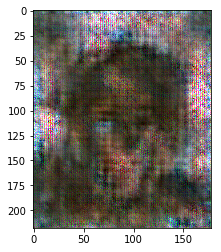

In [114]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 5
nd_steps = 10
ng_steps = 10
dataset = get_data_normalized(500)

for i in range(1000):
    X_batch = get_batch(batch_size, dataset)
    Z_batch = sample_Z(batch_size, 100)
    _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
Z_batch = sample_Z(1, 100)
X_batch = get_batch(1, dataset)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(218,178,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


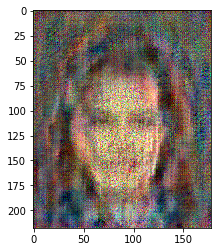

In [49]:
Z_batch = sample_Z(1, 100)
X_batch = get_batch(1, dataset)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(218,178,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


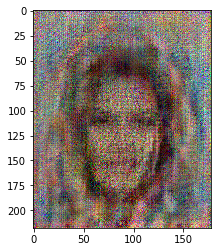

In [50]:
Z_batch = sample_Z(1, 100)
X_batch = get_batch(1, dataset)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(218,178,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


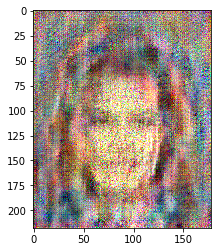

In [51]:
Z_batch = sample_Z(1, 100)
X_batch = get_batch(1, dataset)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(218,178,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))